# When Parts Take the Seat -- Blending Dynamics

**Blending** is one of the most important concepts in IFS. It occurs when a Part's state overwrites the Self's state, assuming control of the system's I/O channels. The individual no longer *observes* the Part -- they *become* it.

When someone says "I am angry", that is blending. When they say "A Part of me is angry", that is unblending -- Self is observing the Part rather than being consumed by it.

This notebook explores:
1. The blending and unblending mechanics
2. The occlusion model (how blending reduces Self-energy)
3. The Feel-Toward gate failing and the recursive fix
4. System metrics: `is_self_led()` and `self_preservation_ratio()`

In [1]:
from agentic_ifs import (
    Manager,
    Firefighter,
    Exile,
    Burden,
    BurdenType,
    ProtectionGraph,
    Edge,
    EdgeType,
    PolarizationEdge,
    SelfSystem,
    BlendState,
    SixFsStateMachine,
    TrailheadLog,
    Trailhead,
    TrailheadType,
    COMPASSION_THRESHOLD,
    is_self_led,
    self_preservation_ratio,
)

import matplotlib.pyplot as plt

# Create Parts
manager = Manager(
    narrative="The Inner Critic -- formed at age 12 after school failure",
    age=12,
    intent="Keep us safe from criticism by being perfect first",
    triggers=["criticism from authority", "perceived failure"],
    strategies=["perfectionism", "over-preparation", "self-criticism"],
    rigidity=0.8,
)

firefighter = Firefighter(
    narrative="The Procrastinator -- shuts down when pressure is too high",
    age=14,
    intent="Protect from overwhelm by stopping all effort",
    pain_threshold=0.6,
    extinguishing_behaviors=["avoidance", "distraction", "numbing"],
)

exile = Exile(
    narrative="The Wounded Child -- carries shame from early school failure",
    age=7,
    intent="Hold the pain so the system can function",
    burden=Burden(
        burden_type=BurdenType.PERSONAL,
        origin="Age 7, school failure",
        content="I am not enough",
        emotional_charge=0.9,
    ),
    emotional_charge=0.7,
)

# Build graph
graph = ProtectionGraph()
graph.add_part(manager)
graph.add_part(firefighter)
graph.add_part(exile)
graph.add_edge(Edge(source_id=manager.id, target_id=exile.id, edge_type=EdgeType.PROTECTS))
graph.add_edge(Edge(source_id=firefighter.id, target_id=exile.id, edge_type=EdgeType.PROTECTS))

# Start with high Self-energy
ss = SelfSystem(self_energy=0.8)
print(f"Initial self_energy: {ss.self_energy}")
print(f"Active blends:      {len(ss.active_blends)}")

Initial self_energy: 0.8
Active blends:      0


## Blending a Part

When we blend a Part, it takes over a percentage of the system's I/O. The `blending_percentage` represents how much control the Part has assumed.

The occlusion formula:

```
self_energy = self_potential * (1 - max_blend)
```

The **most blended Part** determines accessible Self-energy. This models the IFS principle that the dominant Part sets the system's operating mode.

In [2]:
# Blend the Manager at 60%
ss.blend(BlendState(part_id=manager.id, blending_percentage=0.6))

print(f"After blending Manager at 60%:")
print(f"  self_energy:   {ss.self_energy}")
print(f"  is_self_led:   {is_self_led(ss)}")
print(f"  Active blends: {len(ss.active_blends)}")
print()
print(f"Formula: self_energy = {ss.self_potential} * (1 - 0.6) = {ss.self_energy}")

After blending Manager at 60%:
  self_energy:   0.4
  is_self_led:   False
  Active blends: 1

Formula: self_energy = 1.0 * (1 - 0.6) = 0.4


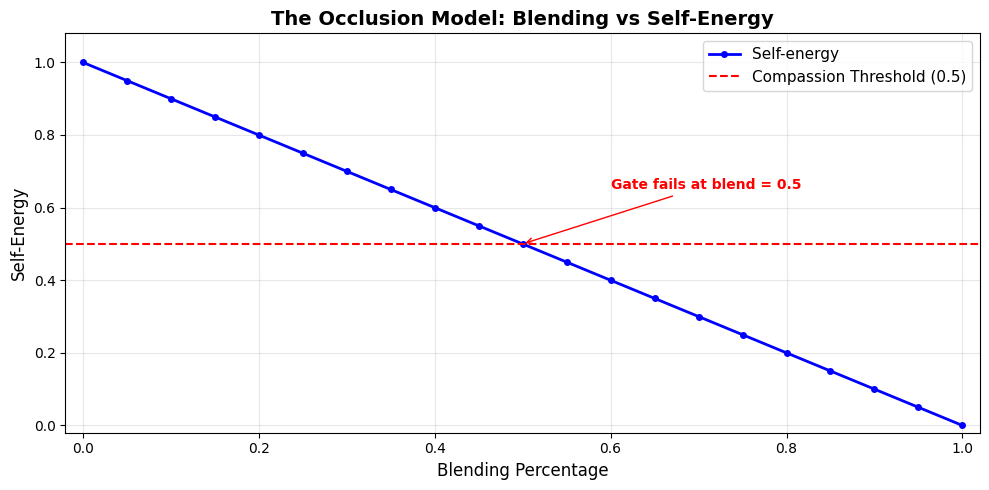

In [3]:
# Blending curve: how self_energy changes as blending_percentage increases
blend_values = [i / 20.0 for i in range(21)]  # 0.0 to 1.0 in steps of 0.05
energy_values = []

for bp in blend_values:
    temp_ss = SelfSystem(self_energy=1.0)
    if bp > 0:
        temp_ss.blend(BlendState(part_id=manager.id, blending_percentage=bp))
    else:
        temp_ss.recalculate()
    energy_values.append(temp_ss.self_energy)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(blend_values, energy_values, 'b-o', markersize=4, linewidth=2, label='Self-energy')
ax.axhline(y=COMPASSION_THRESHOLD, color='red', linestyle='--', linewidth=1.5,
           label=f'Compassion Threshold ({COMPASSION_THRESHOLD})')

# Find the crossover point
crossover = 1.0 - COMPASSION_THRESHOLD
ax.annotate(f'Gate fails at blend = {crossover}',
            xy=(crossover, COMPASSION_THRESHOLD),
            xytext=(crossover + 0.1, COMPASSION_THRESHOLD + 0.15),
            arrowprops=dict(arrowstyle='->', color='red'),
            fontsize=10, color='red', fontweight='bold')

ax.set_xlabel('Blending Percentage', fontsize=12)
ax.set_ylabel('Self-Energy', fontsize=12)
ax.set_title('The Occlusion Model: Blending vs Self-Energy', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.08)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## The Occlusion Model: Max-Blend Determines Self-Energy

When multiple Parts are blended simultaneously, the **most blended Part** determines `self_energy`. This is the max-blend rule:

```
self_energy = self_potential * (1 - max(all blending_percentages))
```

This means: if one Part is at 30% and another at 70%, your Self-energy is determined by the 70%. Unblending the 70% Part drops the max to 30%, and Self-energy recovers accordingly.

In [4]:
# Fresh SelfSystem
ss2 = SelfSystem(self_energy=1.0)
ss2.recalculate()
print(f"No blends:           self_energy = {ss2.self_energy}")

# Blend Manager at 30%
ss2.blend(BlendState(part_id=manager.id, blending_percentage=0.3))
print(f"Manager at 30%:      self_energy = {ss2.self_energy}")

# Blend Firefighter at 70% -- this is now the max
ss2.blend(BlendState(part_id=firefighter.id, blending_percentage=0.7))
print(f"+Firefighter at 70%: self_energy = {ss2.self_energy}  (max determines)")

# Unblend Firefighter -- Manager's 30% is now the max
ss2.unblend(firefighter.id)
print(f"Unblend Firefighter: self_energy = {ss2.self_energy}  (Manager's 30% is now max)")

# Unblend Manager -- fully unblended
ss2.unblend(manager.id)
print(f"Unblend Manager:     self_energy = {ss2.self_energy}  (no blends)")

No blends:           self_energy = 1.0
Manager at 30%:      self_energy = 0.7
+Firefighter at 70%: self_energy = 0.30000000000000004  (max determines)
Unblend Firefighter: self_energy = 0.7  (Manager's 30% is now max)
Unblend Manager:     self_energy = 1.0  (no blends)


## The Feel-Toward Gate in Action

Now let us see what happens when the **Feel-Toward gate fails**. We create a SelfSystem with the Manager blended at 60%, pushing `self_energy` below the `COMPASSION_THRESHOLD` of 0.5. The 6 Fs workflow will detect this and return `unblend_required`.

In [5]:
# Setup: blended system
ss3 = SelfSystem(self_energy=1.0)

graph2 = ProtectionGraph()
graph2.add_part(manager)
graph2.add_part(firefighter)
graph2.add_part(exile)
graph2.add_edge(Edge(source_id=manager.id, target_id=exile.id, edge_type=EdgeType.PROTECTS))
graph2.add_edge(Edge(source_id=firefighter.id, target_id=exile.id, edge_type=EdgeType.PROTECTS))

log2 = TrailheadLog()
workflow2 = SixFsStateMachine(graph=graph2, self_system=ss3, log=log2)

# Blend Manager at 60% -- self_energy drops to 0.4
ss3.blend(BlendState(part_id=manager.id, blending_percentage=0.6))
print(f"Self-energy after blend: {ss3.self_energy}  (<= {COMPASSION_THRESHOLD} threshold)")
print(f"is_self_led: {is_self_led(ss3)}")

# Run the 6 Fs up to Feel Toward
trailhead = Trailhead(
    trailhead_type=TrailheadType.SOMATIC,
    intensity=0.6,
    description="Tightness in chest",
    associated_part_id=manager.id,
)

workflow2.find(trailhead)
workflow2.focus(manager.id)
workflow2.flesh_out(manager.id)

# Feel Toward: THE GATE FAILS
result = workflow2.feel_toward(manager.id)

print(f"\nFeel-Toward result:")
print(f"  next_step:        {result.next_step}  <-- None = blocked")
print(f"  unblend_required: {result.unblend_required}")
print(f"  notes:            {result.notes}")

Self-energy after blend: 0.4  (<= 0.5 threshold)
is_self_led: False

Feel-Toward result:
  next_step:        None  <-- None = blocked
  unblend_required: f595149f-1113-4045-a901-fac1c3bf6433
  notes:            Self-energy insufficient — another Part is blended


In [6]:
# The recursive fix: unblend the interfering Part, then retry
print("--- The Recursive Fix ---")
print(f"Before unblend: self_energy = {ss3.self_energy}")

# Unblend the Manager
ss3.unblend(manager.id)
print(f"After unblend:  self_energy = {ss3.self_energy}")
print(f"is_self_led:    {is_self_led(ss3)}")

# Retry feel_toward -- now it passes
result = workflow2.feel_toward(manager.id)
print(f"\nRetry feel_toward:")
print(f"  next_step:        {result.next_step}  <-- BEFRIEND = gate passes!")
print(f"  unblend_required: {result.unblend_required}")
print(f"  notes:            {result.notes}")

# Continue to befriend and fear
result = workflow2.befriend(manager.id)
print(f"\nBefriend: trust now {manager.trust_level}")

result = workflow2.fear(manager.id)
print(f"Fear: {result.notes}")
print(f"\n6 Fs complete. next_step = {result.next_step}")

--- The Recursive Fix ---
Before unblend: self_energy = 0.4
After unblend:  self_energy = 1.0
is_self_led:    True

Retry feel_toward:
  next_step:        SixFsStep.BEFRIEND  <-- BEFRIEND = gate passes!
  unblend_required: None
  notes:            Self-energy sufficient — Self is present

Befriend: trust now 0.6
Fear: Protects 1 Part(s). Part intent: 'Keep us safe from criticism by being perfect first'

6 Fs complete. next_step = None


## System Metrics

The library provides two key metrics for assessing system state:

- **`is_self_led(self_system)`**: Returns `True` if `self_energy > COMPASSION_THRESHOLD` (0.5). This is the boolean check used by the Feel-Toward gate.

- **`self_preservation_ratio(self_system, graph)`**: The ratio of Self-energy to total Part activation intensity (sum of Exile emotional charges). A high ratio means Self is in the lead; a low ratio means Parts are dominating.

In [7]:
# Demonstrate is_self_led at various self_energy values
print("is_self_led at different self_energy levels:")
print(f"  Threshold = {COMPASSION_THRESHOLD}")
print()

test_energies = [0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0]
for energy in test_energies:
    temp_ss = SelfSystem(self_energy=energy)
    led = is_self_led(temp_ss)
    marker = "  <-- threshold" if energy == COMPASSION_THRESHOLD else ""
    print(f"  self_energy={energy:.1f}  is_self_led={led}{marker}")

print()

# Demonstrate self_preservation_ratio with varying exile charges
print("self_preservation_ratio with self_energy=0.8:")
print()

test_charges = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
for charge in test_charges:
    temp_ss = SelfSystem(self_energy=0.8)
    temp_graph = ProtectionGraph()
    temp_exile = Exile(
        narrative="Test exile",
        age=5,
        intent="Test",
        emotional_charge=charge,
    )
    temp_graph.add_part(temp_exile)
    ratio = self_preservation_ratio(temp_ss, temp_graph)
    print(f"  exile_charge={charge:.1f}  ratio={ratio:.3f}")

is_self_led at different self_energy levels:
  Threshold = 0.5

  self_energy=0.2  is_self_led=False
  self_energy=0.3  is_self_led=False
  self_energy=0.4  is_self_led=False
  self_energy=0.5  is_self_led=False  <-- threshold
  self_energy=0.6  is_self_led=True
  self_energy=0.8  is_self_led=True
  self_energy=1.0  is_self_led=True

self_preservation_ratio with self_energy=0.8:

  exile_charge=0.1  ratio=1.000
  exile_charge=0.3  ratio=1.000
  exile_charge=0.5  ratio=1.000
  exile_charge=0.7  ratio=1.000
  exile_charge=0.9  ratio=0.889
  exile_charge=1.0  ratio=0.800


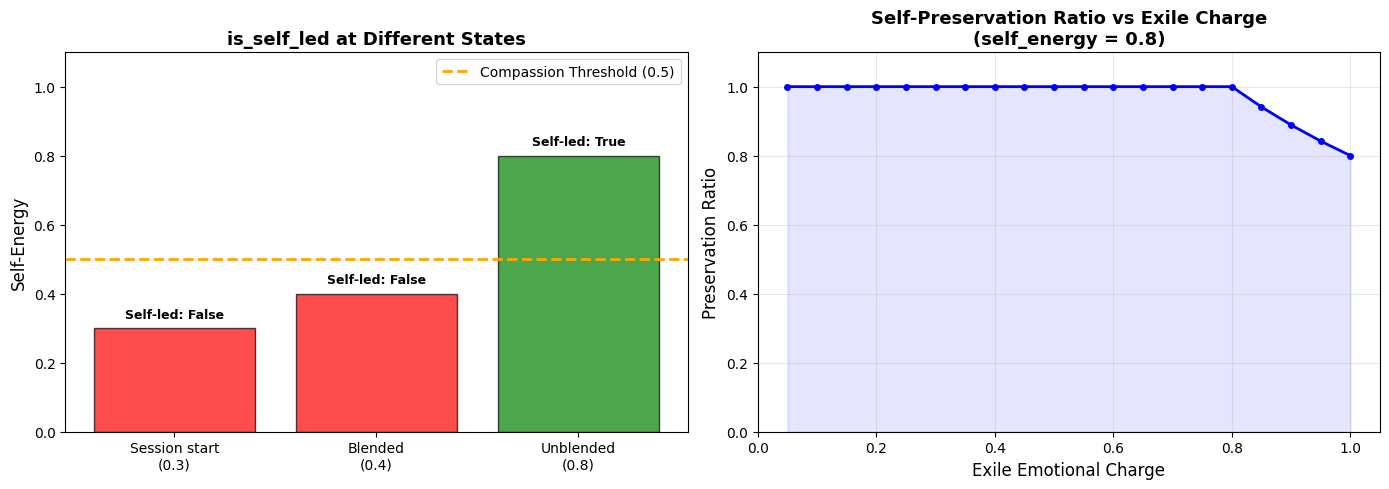

In [9]:
# Metrics visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: is_self_led as a bar chart for 3 states
states = [
    ("Session start\n(0.3)", 0.3),
    ("Blended\n(0.4)", 0.4),
    ("Unblended\n(0.8)", 0.8),
]
state_labels = [s[0] for s in states]
state_values = [s[1] for s in states]
state_colors = ['red' if v <= COMPASSION_THRESHOLD else 'green' for v in state_values]

bars = ax1.bar(state_labels, state_values, color=state_colors, alpha=0.7, edgecolor='black')
ax1.axhline(y=COMPASSION_THRESHOLD, color='orange', linestyle='--', linewidth=2,
            label=f'Compassion Threshold ({COMPASSION_THRESHOLD})')
ax1.set_ylabel('Self-Energy', fontsize=12)
ax1.set_title('is_self_led at Different States', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.set_ylim(0, 1.1)

# Annotate bars
for bar, val in zip(bars, state_values):
    led = val > COMPASSION_THRESHOLD
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.03,
             f"Self-led: {led}", ha='center', fontsize=9, fontweight='bold')

# Right: preservation_ratio as exile charge varies
charges = [i / 20.0 for i in range(1, 21)]  # 0.05 to 1.0
ratios = []
for charge in charges:
    temp_ss = SelfSystem(self_energy=0.8)
    temp_graph = ProtectionGraph()
    temp_exile = Exile(narrative="Test", age=5, intent="Test", emotional_charge=charge)
    temp_graph.add_part(temp_exile)
    ratios.append(self_preservation_ratio(temp_ss, temp_graph))

ax2.plot(charges, ratios, 'b-o', markersize=4, linewidth=2)
ax2.fill_between(charges, ratios, alpha=0.1, color='blue')
ax2.set_xlabel('Exile Emotional Charge', fontsize=12)
ax2.set_ylabel('Preservation Ratio', fontsize=12)
ax2.set_title('Self-Preservation Ratio vs Exile Charge\n(self_energy = 0.8)',
              fontsize=13, fontweight='bold')
ax2.set_xlim(0, 1.05)
ax2.set_ylim(0, 1.1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

Blending and the Feel-Toward gate are the **core innovation** of this library's computational model:

- **Blending** = a Part assumes control, reducing accessible Self-energy via the max-blend occlusion formula
- **The Feel-Toward gate** checks whether Self is genuinely present before allowing therapeutic engagement
- **The recursive check** is what makes IFS clinically distinct: if you feel anger toward a Part, the anger is itself a Part that has blended
- **System metrics** provide quantitative assessment of system state: `is_self_led()` and `self_preservation_ratio()`

This is the mechanism by which IFS prevents bypassing -- it ensures the facilitator (Self) is genuinely present before engaging with a Part. In computational terms, it is an access control check that prevents a blended Part from masquerading as Self.

**Next:** In [05_full_scenario.ipynb](05_full_scenario.ipynb), we bring everything together in a realistic clinical scenario using the `Session` facade.